# Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [2]:
## Now, we import timm, torchvision image models
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy # This is better than normal nn.CrossEntropyLoss

In [3]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sys
from tqdm import tqdm
import time
import copy
import matplotlib.pyplot as plt
%matplotlib inline

# Helper functions for pytorch dataloaders

In [5]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [6]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomRotation(degrees=5),
#             T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
#             T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data)

In [7]:
# path of the database
dataset_path = "/kaggle/input/alcohol-3/train_test_split/train_test_split"

In [8]:
# loading a batch of 128 for training purpose while a batch of 32 for testing and validation 
(train_loader, train_data_len) = get_data_loaders(dataset_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len) = get_data_loaders(dataset_path, 32, train=False)

In [9]:
classes = get_classes("/kaggle/input/alcohol-3/train_test_split/train_test_split/train")
print(len(classes))

2


In [10]:
dataloaders = {
    "train": train_loader,
    "val": val_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len
}

In [11]:
print(len(train_loader), len(val_loader), len(test_loader))

175 219 220


In [12]:
print(train_data_len, valid_data_len, test_data_len)

22307 7004 7011


### Thus, there are 22307 train, 7004 validation and 7011 testing images.

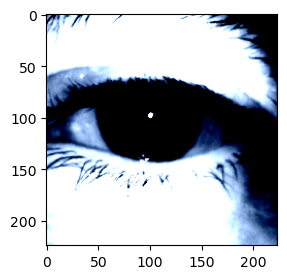

In [13]:
# Displaying transformed image
i = 0
for data in train_loader:
    plt.figure(figsize=(4,3))
    plt.imshow(data[0][24].permute(1,2,0))
    break

In [ ]:
# printing the shape
for data in test_loader:
    print(data[0].shape)
    break

torch.Size([32, 3, 224, 224])


In [ ]:
# now, for the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Loading the model and adding Feed Forward Neural layer

In [ ]:
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

In [17]:
for param in model.parameters(): #freeze model
    param.requires_grad = False

# n_inputs = model.head.in_features 
model.head = nn.Sequential(
    nn.Linear(192, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 128),
    nn.Linear(128, 32),
    nn.Linear(32,len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=256, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): Linear(in_features=128, out_features=32, bias=True)
  (5): Linear(in_features=32, out_features=2, bias=True)
)


# Defining the hyper-parameters of the model

In [18]:
criterion = LabelSmoothingCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001)

In [19]:
# lr scheduler
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

# Training the model

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)
        
        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate
            
            running_loss = 0.0
            running_corrects = 0.0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step() # step at end of epoch
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]
            
            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [21]:
# for removing error while loading image using PIL
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler) # now it is a lot faster

Epoch 0/14
----------


100%|██████████| 175/175 [02:45<00:00,  1.06it/s]


train Loss: 0.4170 Acc: 0.8642


100%|██████████| 219/219 [00:45<00:00,  4.78it/s]


val Loss: 0.3724 Acc: 0.9116

Epoch 1/14
----------


100%|██████████| 175/175 [02:13<00:00,  1.31it/s]


train Loss: 0.3493 Acc: 0.9105


100%|██████████| 219/219 [00:36<00:00,  5.93it/s]


val Loss: 0.3226 Acc: 0.9390

Epoch 2/14
----------


100%|██████████| 175/175 [02:14<00:00,  1.30it/s]


train Loss: 0.3169 Acc: 0.9389


100%|██████████| 219/219 [00:35<00:00,  6.11it/s]


val Loss: 0.2896 Acc: 0.9562

Epoch 3/14
----------


100%|██████████| 175/175 [02:14<00:00,  1.31it/s]


train Loss: 0.3013 Acc: 0.9503


100%|██████████| 175/175 [02:27<00:00,  1.19it/s]


train Loss: 0.2906 Acc: 0.9553


100%|██████████| 219/219 [00:35<00:00,  6.18it/s]


val Loss: 0.2758 Acc: 0.9650

Epoch 5/14
----------


100%|██████████| 175/175 [02:13<00:00,  1.31it/s]


train Loss: 0.2811 Acc: 0.9609


100%|██████████| 219/219 [00:35<00:00,  6.09it/s]


val Loss: 0.2666 Acc: 0.9722

Epoch 6/14
----------


100%|██████████| 175/175 [02:13<00:00,  1.31it/s]


train Loss: 0.2760 Acc: 0.9662


100%|██████████| 219/219 [00:36<00:00,  6.01it/s]


val Loss: 0.2603 Acc: 0.9750

Epoch 7/14
----------


100%|██████████| 175/175 [02:13<00:00,  1.31it/s]


train Loss: 0.2694 Acc: 0.9688


100%|██████████| 219/219 [00:36<00:00,  6.08it/s]


val Loss: 0.2595 Acc: 0.9742

Epoch 8/14
----------


100%|██████████| 175/175 [02:14<00:00,  1.30it/s]


train Loss: 0.2660 Acc: 0.9701


100%|██████████| 219/219 [00:37<00:00,  5.89it/s]


val Loss: 0.2549 Acc: 0.9789

Epoch 9/14
----------


100%|██████████| 175/175 [02:17<00:00,  1.27it/s]


train Loss: 0.2641 Acc: 0.9713


100%|██████████| 219/219 [00:36<00:00,  6.06it/s]


val Loss: 0.2515 Acc: 0.9787

Epoch 10/14
----------


100%|██████████| 175/175 [02:12<00:00,  1.32it/s]


train Loss: 0.2613 Acc: 0.9736


100%|██████████| 219/219 [00:35<00:00,  6.16it/s]


val Loss: 0.2514 Acc: 0.9799

Epoch 11/14
----------


100%|██████████| 175/175 [02:11<00:00,  1.33it/s]


train Loss: 0.2588 Acc: 0.9757


100%|██████████| 219/219 [00:35<00:00,  6.17it/s]


val Loss: 0.2489 Acc: 0.9809

Epoch 12/14
----------


100%|██████████| 175/175 [02:12<00:00,  1.32it/s]


train Loss: 0.2587 Acc: 0.9753


100%|██████████| 219/219 [00:35<00:00,  6.17it/s]


val Loss: 0.2481 Acc: 0.9787

Epoch 13/14
----------


100%|██████████| 175/175 [02:11<00:00,  1.33it/s]


train Loss: 0.2561 Acc: 0.9773


100%|██████████| 219/219 [00:35<00:00,  6.20it/s]


val Loss: 0.2536 Acc: 0.9763

Epoch 14/14
----------


100%|██████████| 175/175 [02:10<00:00,  1.34it/s]


train Loss: 0.2555 Acc: 0.9769


100%|██████████| 219/219 [00:35<00:00,  6.19it/s]

val Loss: 0.2462 Acc: 0.9810

Training complete in 43m 15s
Best Val Acc: 0.9810


We achieved a validation accuracy of 98.10% with a training time of 43 mins and 15 sec.

# Testing

Ok, now we finished training. Lets run the dataset on the test loader and calculate accuracy

In [23]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
model.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = model(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if i > 0:
        print("Test Accuracy of alcoholic class: %2d%% (%2d/%2d)" % (
             100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of non-alcoholic class: %2d%% (%2d/%2d)" % (
             100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        )) 
        
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 220/220 [00:46<00:00,  4.78it/s]

Test Loss: 0.0001
Test accuracy of non-alcoholic class: 96% (3429/3543)
Test Accuracy of alcoholic class: 99% (3441/3465)
Test Accuracy of 98% (6870/7008)


Our model finally earned a 98% test accuracy. 

# Evaluating on a random image

-> For inference purposes

In [43]:
for i in test_loader:
    random_img = i[0][10]
    break
random_img.shape

torch.Size([3, 224, 224])

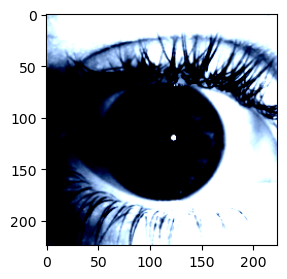

In [44]:
arr_ = np.array(random_img.permute(1,2,0))
plt.figure(figsize=(4,3))
plt.imshow(arr_)
plt.show()

In [46]:
# predicted class label
random_img = random_img.unsqueeze(0).to(device)
model.eval()
with torch.no_grad():
    class_index = model(random_img).argmax()
    print(class_index)

tensor(1, device='cuda:0')


In [48]:
# true class label
i[1][10]

tensor(1)

Thus, our model is predicting correctly on an inference images too and the image belongs to alcoholic class.

# Quantizing and scripting the model

Applying dynamic quantization to reduce the size of trained model while ensuring accuracy remains same.
Using fbgemm backend for x86 CPU. After that, scripting is done to convert pytorch model to Torchscript model.

### Note : Pytorch 1.9.1 do not support quantized operator implementation on CUDA, so we need to transfer model back to cpu for quantization.

In [28]:
backend = 'fbgemm'
model_quant_config = torch.quantization.get_default_qconfig(backend)
print(model_quant_config)

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})


In [29]:
torch.backends.quantized.engine = backend
quantized_model = torch.quantization.quantize_dynamic(model.to('cpu'), qconfig_spec={torch.nn.Linear}, dtype=torch.float16)

In [30]:
# Utilizing a Just In Compiler(jit) to script the quantized model
script_quantized_model = torch.jit.script(quantized_model.cpu())
script_quantized_model.save("weights/binaryclass_quantized_deit.pt")

# Optimizing the model

### Running a list of optimization pass with modules in evaluation mode. This improves the model overall graph for better optimizationm. Following is the optimization list applied :
    1 -> Freezing the useless attributes of the module
    2 -> Inlining the function to remove function call overhead
    3 -> Fusing the intermediate layers such as conv-batchnorm or conv-relu
    4 -> Removing the Dropout to improve the performance of the model

In [ ]:
from torch.utils.mobile_optimizer import optimize_for_mobile
scripted_quantized_model = torch.load(r'weights/binaryclass_quantized_deit.pt')

In [4]:
optimized_scripted_quantized_model = optimize_for_mobile(scripted_quantized_model)
optimized_scripted_quantized_model.save("weights/binaryclass_optimized_deit.pt")

# Saving for inference on lite interpreter devices such as mobile 

Adding mobile specific bytecode to the optimized Torchscript model to produce the lite interpreter model. Doing this ensures that PyTorch saves additional bytecode for the model’s graph, which is more efficient to execute on device compared to TorchScript. PyTorch also uses lesser binary size in the compiled app relative to running TorchScript.

In [5]:
optimized_scripted_quantized_model._save_for_lite_interpreter('weights/binaryclass_optimized_lite_deit.ptl')